<a href="https://colab.research.google.com/github/nishanthta/Offline-Signature-Verification/blob/master/MyCapsNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports including CIFAR 10 (included in keras.datasets) and ImageDataGenerator provided by Keras for data augmentation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!pip install -I keras==2.1.6

In [3]:
from __future__ import print_function
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import *
from keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
K.tensorflow_backend.clear_session()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.visible_device_list = "0"
session = tf.Session(config=config)
K.tensorflow_backend.set_session(session)

Using TensorFlow backend.


Squash function, using $0.5$ instead of $1$ in the denominator to squash the capsules

> Indented block



$squash(x) =||x|| / (0.5 + ||x||^2)$

In [0]:
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

We define our own $softmax$ function as the one provided by Keras does not include the provision to specify axis 

In [0]:
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

Margin loss, implemented as described in Hinton's paper

In [0]:
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)

Capsules, as implemented in https://github.com/bojone/Capsule/

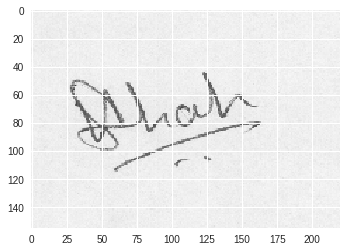

In [7]:
data_dir = "/content/drive/My Drive/CEDAR"
img = image.load_img(data_dir + "/full_org/original_22_18.png", target_size = (155,220,1))
plt.imshow(img)

In [8]:
import os
img_height, img_width = 155, 220
input_shape = (155, 220, 1)
def create_data(height,width,data_dir):
    files_list = os.listdir(data_dir)
    files = ["/content/drive/My Drive/CEDAR/full_org/" + f for f in files_list]
    nb_classes = 55 #cedar dataset
    # filename from path: file.rsplit('/', 1)[-1]
    # cedar data specific, will get 1_1; original from start and .png from end removed
    img_names = [file.rsplit('/', 1)[-1][9:-4] for file in files]
    print(img_names)
    data = []
    labels = []
    print(len(img_names))
    for i in range(len(img_names)):
      print(i)
      try:
        class_index = int(img_names[i].split('_',1)[0])
        label = class_index - 1
        img = image.load_img(files[i], grayscale = True, target_size=(height, width))
        img = image.img_to_array(img)#, dim_ordering='tf')
        data.append(img)
        labels.append(label)
      except ValueError:
        print("invalid file")

    return np.array(data), np.array(labels), nb_classes


def create_forged_data(height,width,data_dir):
    files_list = os.listdir(data_dir)
    files = ["/content/drive/My Drive/CEDAR/full_forg/" + f for f in files_list]
    nb_classes = 55 #cedar dataset
    # filename from path: file.rsplit('/', 1)[-1]
    # cedar data specific, will get 1_1; original from start and .png from end removed
    img_names = [file.rsplit('/', 1)[-1][10:-4] for file in files]
    print(img_names)
    data = []
    labels = []
    print(len(img_names))
    for i in range(len(img_names)):
      print(i)
      try:
        class_index = int(img_names[i].split('_',1)[0])
        label = class_index - 1
        img = image.load_img(files[i], grayscale = True, target_size=(height, width))
        img = image.img_to_array(img)#, dim_ordering='tf')
        data.append(img)
        labels.append(label)
      except ValueError:
        print("invalid file")

    return np.array(data), np.array(labels), nb_classes

xt, yt, nbclasses = create_data(img_height, img_width, '/content/drive/My Drive/CEDAR/full_org/')
xft, yft, _ = create_forged_data(img_height, img_width, '/content/drive/My Drive/CEDAR/full_forg/')
print("Size of dataset : ", xft.shape, "\nSize of labels : ", len(yft))

['22_18', '22_2', '22_19', '22_17', '22_21', '22_22', '22_8', '22_3', '22_23', '22_5', '22_24', '22_4', '22_9', '23_10', '22_6', '22_7', '23_1', '23_11', '23_12', '23_13', '23_19', '23_14', '23_15', '23_18', '23_2', '23_16', '23_17', '23_21', '23_20', '23_22', '23_4', '23_23', '23_3', '23_24', '23_8', '23_9', '23_5', '23_7', '23_6', '24_1', '24_11', '24_10', '24_12', '24_13', '24_16', '24_17', '24_19', '24_14', '24_15', '24_18', '24_2', '24_20', '24_22', '24_21', '24_23', '24_24', '24_4', '24_7', '24_3', '24_5', '24_6', '24_8', '25_1', '24_9', '25_11', '25_10', '25_13', '25_14', '25_12', '25_15', '25_18', '25_17', '25_16', '25_19', '25_21', '25_2', '25_23', '25_20', '25_22', '25_24', '25_7', '25_5', '25_4', '25_3', '25_6', '25_9', '26_10', '26_11', '25_8', '26_15', '26_12', '26_16', '26_1', '26_14', '26_13', '26_18', '26_17', '26_19', '26_2', '26_5', '26_20', '26_4', '26_21', '26_22', '26_23', '26_24', '26_3', '26_6', '26_7', '26_8', '26_9', '27_12', '27_1', '27_10', '27_11', '27_15', 

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [9]:
freq = np.zeros(len(yft) + 1)
for i in yft:
  freq[i] += 1
for i in range(nbclasses):
  print("Number of examples in class ", i, " is ", freq[i])

Number of examples in class  0  is  24.0
Number of examples in class  1  is  24.0
Number of examples in class  2  is  24.0
Number of examples in class  3  is  24.0
Number of examples in class  4  is  24.0
Number of examples in class  5  is  24.0
Number of examples in class  6  is  24.0
Number of examples in class  7  is  24.0
Number of examples in class  8  is  24.0
Number of examples in class  9  is  24.0
Number of examples in class  10  is  24.0
Number of examples in class  11  is  24.0
Number of examples in class  12  is  24.0
Number of examples in class  13  is  24.0
Number of examples in class  14  is  24.0
Number of examples in class  15  is  24.0
Number of examples in class  16  is  24.0
Number of examples in class  17  is  24.0
Number of examples in class  18  is  24.0
Number of examples in class  19  is  24.0
Number of examples in class  20  is  24.0
Number of examples in class  21  is  24.0
Number of examples in class  22  is  24.0
Number of examples in class  23  is  24.0
Nu

In [10]:
from sklearn.model_selection import train_test_split

lbound = 12144
ubound = 18216

def generate_train(xt, yt, nbclasses):
  x_class = [[] for i in range(nbclasses)]
  xf_class = [[] for i in range(nbclasses)]
  x1_train, x2_train, y_train = [], [], []
  cnt = 0
  for i in range(nbclasses):
    x_class[i] = xt[np.where(yt == i)]
    xf_class[i] = xft[np.where(yft == i)]
  for signer in range(nbclasses):
    for i in range(24):
      for j in range(i + 1, 24):
        x1_train.append(x_class[signer][i])
        x2_train.append(x_class[signer][j])
        y_train.append(1)
        cnt += 1
  tempx1_train, tempx2_train = [], []
  for signer in range(nbclasses):
    for i in range(24):
      for j in range(24):
        tempx1_train.append(x_class[signer][i])
        tempx2_train.append(xf_class[signer][j])
    
    indices = np.arange(576)
    np.random.shuffle(indices)
    
    for i in range(276):
      x1_train.append(tempx1_train[indices[i]])
      x2_train.append(tempx2_train[indices[i]])
      y_train.append(0)
  
  
        
  return np.array(x1_train), np.array(x2_train), np.array(y_train)
        
x1_train, x2_train, y_train = generate_train(xt, yt, nbclasses)

for i in range(len(x1_train)):
  x1_train[i] = x1_train[i].astype('float32')
  x2_train[i] = x2_train[i].astype('float32')
  x1_train[i] /= 255.0
  x2_train[i] /= 255.0
  
# x1_test, x2_test, y_test = x1_train[lbound:ubound], x2_train[lbound:ubound], y_train[lbound:ubound]
# x1_train, x2_train, y_train = np.concatenate((x1_train[:lbound], x1_train[ubound:]), axis = 0), np.concatenate((x2_train[:lbound], x2_train[ubound:]), axis = 0), np.concatenate((y_train[:lbound], y_train[ubound:]), axis = 0)

  
# x1test, x2test, ytest = np.zeros(shape = (None, 155, 220, 1)),np.zeros(shape = (None, 155, 220, 1)),np.zeros(shape = (None, 155, 220, 1))

# [x1_train, x2_train], [x1test, x2test], y_train, ytest = train_test_split([x1_train, x2_train], y_train, test_size = 0.1)  
  
print("Shape of x1_train : ", x1_train[30000].shape, "\nShape of x2_train : ", len(x2_train), "\nShape of y_train : ", len(y_train))

# for i in range(nbclasses):
#   print(len(x_class[i]))

# sample = image.array_to_img(x_class[5][23])
# plt.imshow(sample)

Shape of x1_train :  (155, 220, 1) 
Shape of x2_train :  30360 
Shape of y_train :  30360


In [0]:
#Manually generate training and test pairs
# indices = np.arange(30360)
# np.random.shuffle(indices)
# nbr_train = int(0.9*30360)
# nbr_val, nbr_test = int(0.05*30360), int(0.05*30360)

# x1train, x2train, x1val, x2val, x2test, x1test, ytrain, yval, ytest = [],[],[],[],[],[],[],[],[]

# for i in range(nbr_train):
#   x1train.append(x1_train[indices[i]])
#   x2train.append(x2_train[indices[i]])
#   ytrain.append(y_train[i])
#   print(i)
#   train1,train2,trainy = np.array(x1train),np.array(x2train),np.array(ytrain) 
  
# for i in range(nbr_train + 1, nbr_train + nbr_val):
#   x1val.append(x1_train[indices[i]])
#   x2val.append(x2_train[indices[i]])
#   yval.append(y_train[i])
#   val1,val2,valy = np.array(x1val),np.array(x2val),np.array(yval) 

# for i in range(nbr_train + nbr_val + 1, 30360):
#   x1test.append(x1_train[indices[i]])
#   x2test.append(x2_train[indices[i]])
#   ytest.append(y_train[i])
#   test1,test2,testy = np.array(x1test),np.array(x2test),np.array(ytest) 
  
# x1train, x2train, x1val, x2val, x2test, x1test, ytrain, yval, ytest, x1_train, x2_train, y_train = None

# print(train1.shape, " ",train2.shape, " ",val1.shape, " ",val2.shape, " ",test1.shape, " ",test2.shape, " ",trainy.shape, " ",testy.shape)

y  is  1


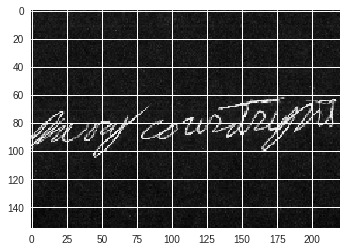

In [12]:
plt.imshow(image.array_to_img(x1_train[15000]))
print("y  is ", y_train[15000])

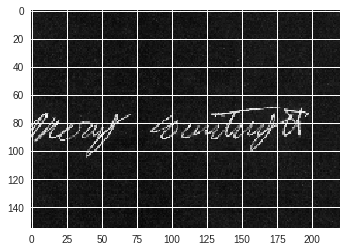

In [13]:
plt.imshow(image.array_to_img(x2_train[15000]))

In [0]:
class Capsule(Layer):
    """
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).
    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.
        This change can improve the feature representation of Capsule.
        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [0]:
batch_size = 128
epochs = 100

In [0]:
def euclidean_distance(vects):
    assert len(vects) == 2, \
        'Distance needs 2 inputs, %d given' % len(inputs)
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))
    


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
  
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''

    # y_pred --> Dw, euclidean distance computed in the embedded space

    """ What you want is double the distance if the pairs are equal - 
    this is the loss for pairs should be be with "zero" distance. 
    But if the pairs are distinct from each other you want to calculate
    their distance from the margin and double it.
    """

    margin = 1

    """ Dw to be close to 0 when y_true is 1 (for positive pairs) and 
        Dw close or bigger than 1 when y_true is 0 (for negative pairs)
        Distance low for similar pairs and high for diff images
    """    
    
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [0]:
from keras.models import Sequential
from keras.regularizers import l2
input_shape = (155, 220, 1)
def create_base_network(input_shape):
  seq = Sequential()
  seq.add(Convolution2D(96, 11, 11, activation='relu', name='conv1_1', subsample=(4, 4), input_shape= input_shape, 
                      init='glorot_uniform', dim_ordering='tf'))
  #seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
  seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
  seq.add(ZeroPadding2D((2, 2), dim_ordering='tf'))

  seq.add(Convolution2D(256, 5, 5, activation='relu', name='conv2_1', subsample=(1, 1), init='glorot_uniform',  dim_ordering='tf'))
  #seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
  seq.add(MaxPooling2D((3,3), strides=(2, 2)))
  seq.add(Dropout(0.3))# added extra
  seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))

  seq.add(Convolution2D(384, 3, 3, activation='relu', name='conv3_1', subsample=(1, 1), init='glorot_uniform',  dim_ordering='tf'))
  seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))

  seq.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2', subsample=(1, 1), init='glorot_uniform', dim_ordering='tf'))    
  seq.add(MaxPooling2D((3,3), strides=(2, 2)))
  seq.add(Dropout(0.3))# added extra
  #seq.add(SpatialPyramidPooling([1, 2, 4]))
  seq.add(Flatten(name='flatten'))
  seq.add(Dense(1024, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform'))
  seq.add(Dropout(0.5))
  
  seq.add(Reshape(target_shape = (-1, 128)))
  
  seq.add(Capsule(32,20,3,True))
  
  seq.add(Flatten())

  seq.add(Dense(128, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform')) # softmax changed to relu

  return seq

In [18]:
from keras.optimizers import RMSprop

base_network = create_base_network(input_shape)

print(base_network.summary())

input_a = Input(shape = (input_shape))
input_b = Input(shape = (input_shape))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

predictions = Dense(1, activation = 'sigmoid')(distance)

model = Model(inputs=[input_a, input_b], outputs=predictions)

rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)

model.compile(loss = 'binary_crossentropy', optimizer = rms, metrics = ['accuracy'])

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (11, 11), activation="relu", name="conv1_1", input_shape=(155, 220,..., strides=(4, 4), data_format="channels_last", kernel_initializer="glorot_uniform")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D((2, 2), data_format="channels_last")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (5, 5), activation="relu", name="conv2_1", strides=(1, 1), data_format="channels_last", kernel_initializer="glorot_uniform")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D((1, 1), data_format="chann

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 37, 53, 96)        11712     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 26, 96)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 22, 30, 96)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 18, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 12, 256)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 12, 256)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 10, 14, 256)       0         
__________

In [0]:
# from keras.optimizers import Adam
# # input_a = Input(shape=(input_shape))
# # input_b = Input(shape=(input_shape))

# # base_model = base_network(Input(shape = (input_shape)))

# # print(base_model.summary())

# # processed_a = base_model(input_a)
# # processed_b = base_model(input_b)

# # distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

# # predictions = Dense(1, activation = 'sigmoid')(distance)

# main_model = Model(inputs=[input_a, input_b], outputs=predictions)

# adam = Adam(lr = 0.01)

# main_model.compile(loss=contrastive_loss, optimizer=adam, metrics=['accuracy'])
# print(main_model.summary())

In [0]:
history = model.fit(x = [np.concatenate((x1_train[:lbound], x1_train[ubound:]), axis = 0), np.concatenate((x2_train[:lbound], x2_train[ubound:]), axis = 0)], y = np.concatenate((y_train[:lbound], y_train[ubound:]), axis = 0), epochs = 25, batch_size = batch_size, shuffle = True, validation_data = ([x1_train[lbound:ubound], x2_train[lbound:ubound]], y_train[lbound:ubound]))
#

In [0]:
preds = model.predict([x1_train[13000:16000], x2_train[13000:16000]])
for i in range(13000,16000):
  print("preds ", preds[i - 13000], " true ", y_train[i])